In [414]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import shutil
from scipy.signal import argrelextrema
from scipy.signal import find_peaks
import numpy as np

In [300]:
def get_data(fn):
    df = pd.read_csv(fn)
    # normalized the data to range 0-1
    # for feat_name in df.columns:
    #     col_max[feat_name] = df[feat_name].max()
    #     df[feat_name] = df[feat_name].transform(lambda x: x/x.max())
    return df

os.mkdir("results/power")

In [381]:
POWER_DATA_PATH = "./power_data.csv"
PERFORMANCE_DATA_PATH = "./power_timing_breakpoints.csv"

power_df = get_data(POWER_DATA_PATH)[2500:]
perf_df = get_data(PERFORMANCE_DATA_PATH)

In [382]:
TIME_DRIFT = perf_df.iloc[-1]['Endtime']/(power_df.iloc[-1]['Time (s)']*1000)

In [383]:
print(perf_df.iloc[112])

Unnamed: 0                  1.120000e+02
CPU Frequencies             4.000000e+05
GPU Frequencies             6.000000e+08
Mem Frequencies             1.650000e+08
Initialization Time         4.495920e+03
Allocation Time             2.528800e+01
Copy To Device Time         2.239476e+03
Kernel Time                 9.133611e+03
Copy Back and Merge Time    1.490001e+03
Deallocation Time           5.546500e+01
Real Time                   3.315600e+04
User Time                   1.179100e+04
System Time                 6.203000e+03
Starttime                   3.564556e+06
Endtime                     3.597763e+06
Name: 112, dtype: float64


In [508]:
def get_perf_idx_range(perf_idx):
    return int(perf_df.iloc[perf_idx]['Starttime']/TIME_DRIFT), int(perf_df.iloc[perf_idx]['Endtime']/TIME_DRIFT)

def get_plot_data(start, end):
#     start = int(perf_df.iloc[perf_idx]['Starttime']/TIME_DRIFT)
#     end = int(perf_df.iloc[perf_idx]['Endtime']/TIME_DRIFT)
#     print(start, end)
    data = power_df.iloc[int(start*0.5):int(end*0.5)]
    l = len(data)
    l10 = int(l*0.15)
    n = 10 + min(50, int(l*0.0025))
    data_trim = data.iloc[l10:-l10]
    
    local_mins = data_trim.iloc[argrelextrema(data_trim['Main Avg Power (W)'].values, np.less_equal,
                    order=n)[0]]['Main Avg Power (W)']
    local_maxs = data_trim.iloc[argrelextrema(data_trim['Main Avg Power (W)'].values, np.greater_equal,
                    order=n)[0]]['Main Avg Power (W)']
    
    power_idle = round(local_mins.mean(),3)
    power_active = round(local_maxs.mean(),3)
    
    return data, power_idle, power_active

def plot_power_graph(perf_idx):
#     start = int(perf_df.iloc[perf_idx]['Starttime']/TIME_DRIFT)
#     end = int(perf_df.iloc[perf_idx]['Endtime']/TIME_DRIFT)
#     data = power_df.iloc[int(start*0.5):int(end*0.5)]
#     l = len(data)
#     l10 = int(l*0.15)
#     n = 10 + min(50, int(l*0.0025))
#     data_trim = data.iloc[l10:-l10]
    
#     local_mins = data_trim.iloc[argrelextrema(data_trim['Main Avg Power (W)'].values, np.less_equal,
#                     order=n)[0]]['Main Avg Power (W)']
#     local_maxs = data_trim.iloc[argrelextrema(data_trim['Main Avg Power (W)'].values, np.greater_equal,
#                     order=n)[0]]['Main Avg Power (W)']
    
#     power_idle = round(local_mins.mean(),3)
#     power_active = round(local_maxs.mean(),3)
    
#     print(perf_idx, power_idle, power_active)
    start, end = get_perf_idx_range(perf_idx)
    data, power_idle, power_active = get_plot_data(start, end)
    
    plt.plot(data["Time (s)"], data["Main Avg Power (W)"])
    plt.axhline(y = power_active, color = 'g', linestyle = '-')
    plt.axhline(y = power_idle, color = 'r', linestyle = '-')
    plt.title("Performance Idx: {}/Idle:{}/Active:{}".format(perf_idx, power_idle, power_active))
    plt.xlabel("Time")
    plt.ylabel("Power")
    plt.savefig('./results/power/power_perf_{}.png'.format(perf_idx))
    plt.close()

In [489]:
# for i in range(len(perf_df[:-70])):
#     get_power_plot(i)
a, b, c = get_plot_data(0)
print(b, c)

TypeError: get_plot_data() missing 1 required positional argument: 'end'

In [449]:
data = power_df.iloc[int(47290.0*0.5):int(159189.0*0.5)]
# data = power_df.iloc[int(11925281*0.5):int(11984539*0.5)]
# data = power_df.iloc[int(9399873*0.5):int(9413332*0.5)]
# data = power_df.iloc[int(3538197*0.5):int(3650634*0.5)]
# data = power_df.iloc[int(15035270*0.5):int(15044821*0.5)]
# data = power_df.iloc[int(start*0.5):int(end*0.5)]
l = len(data)
l10 = int(l*0.15)
n = 10 + min(50, int(l*0.0025))
data_trim = data.iloc[l10:-l10]

local_mins = data_trim.iloc[argrelextrema(data_trim['Main Avg Power (W)'].values, np.less_equal,
                order=n)[0]]['Main Avg Power (W)']

dips, bumps = find_peaks(-data["Main Avg Power (W)"]), find_peaks(data["Main Avg Power (W)"])

print(dips)

local_maxs = data_trim.iloc[argrelextrema(data_trim['Main Avg Power (W)'].values, np.greater_equal,
                order=n)[0]]['Main Avg Power (W)']

power_idle = round(local_mins.mean(),3)
power_active = round(local_maxs.mean(),3)

print(power_idle, power_active)

(array([    2,     4,     7, ..., 55940, 55942, 55946]), {})
2.195 3.67


In [450]:
local_dips = data_trim.iloc[argrelextrema(data_trim['Main Avg Power (W)'].values, np.less_equal,
                order=3500)[0]]

print(local_dips.loc[ local_dips["Main Avg Power (W)"] <= (power_idle*0.95) ])
# plt.plot()

       Time (s)  Main Avg Power (W)  Main Min Power (W)  Main Max Power (W)
44895     89.79              2.0414              2.0309              5.8375
63370    126.74              2.0596              2.0309              5.8375


In [509]:
ranges = []

def get_dips_and_block(stime, window_s = 60):
    starttime = stime
    endtime = starttime + window_s * 1000
    data, power_idle, power_active = get_plot_data(starttime, endtime)
    local_dips = data.iloc[argrelextrema(data['Main Avg Power (W)'].values, np.less_equal,
                order=3500)[0]]
    absolute_dips = local_dips.loc[ local_dips["Main Avg Power (W)"] <= (power_idle*0.95) ]
#     print(absolute_dips)
#     print(power_idle, power_active)
    plt.figure()
    plt.plot(data["Time (s)"], data["Main Avg Power (W)"])
    plt.axhline(y = power_active, color = 'g', linestyle = '-')
    plt.axhline(y = power_idle, color = 'r', linestyle = '-')
    plt.title("Power")
    plt.xlabel("Time")
    plt.ylabel("Power")
    plt.show()
    return starttime, int(absolute_dips.iloc[0]["Time (s)"]*1000)
        

In [510]:
# get_dips_and_block(403)

In [511]:
# print(ranges)

In [512]:
def final():
    start = int(perf_df.iloc[0]['Starttime'])
    
    for i in range(20):
        start, end = get_dips_and_block(start)
        real_time = int(perf_df.iloc[i]['Real Time'])
        duration = end-start
        print(duration, real_time)
        if(duration/real_time > 1.7 or real_time/duration > 1.7):
            start = start + real_time
        else:
            start = end
        
        print("next start: {}".format(start))

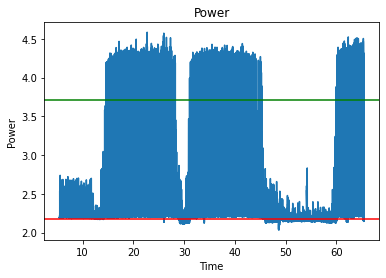

48281 46363
next start: 48686


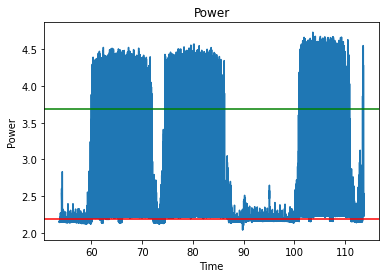

41104 40930
next start: 89790


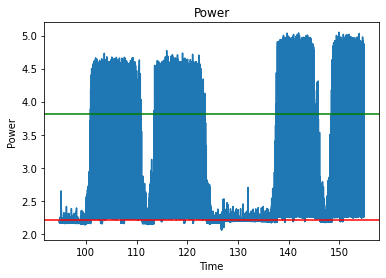

36950 36717
next start: 126740


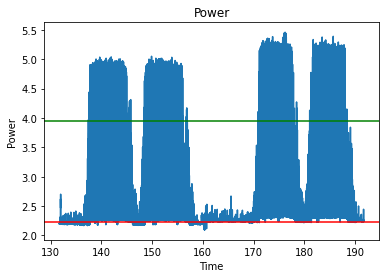

33588 33387
next start: 160328


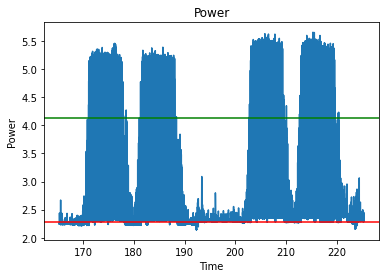

32036 31822
next start: 192364


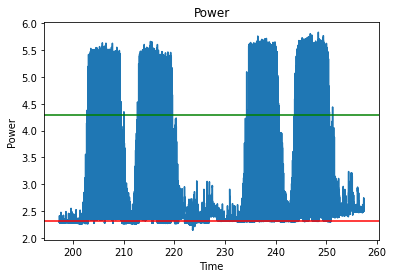

31274 31200
next start: 223638


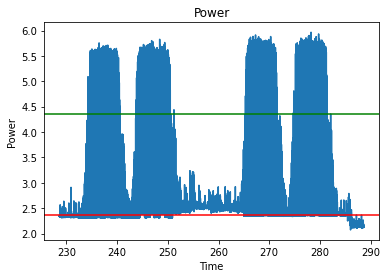

62392 30859
next start: 254497


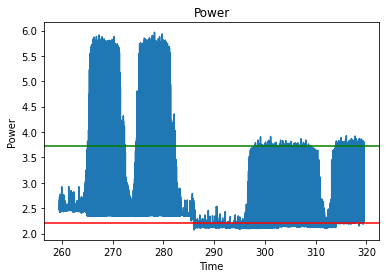

31533 30656
next start: 286030


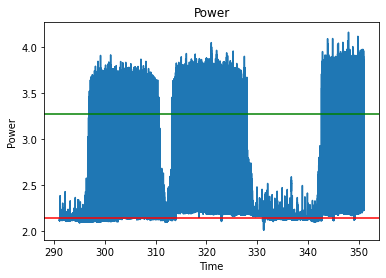

45266 45693
next start: 331296


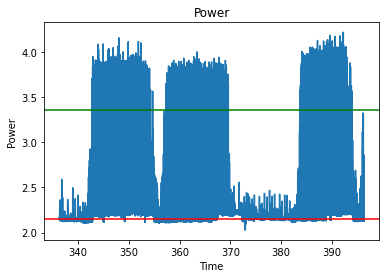

41574 41342
next start: 372870


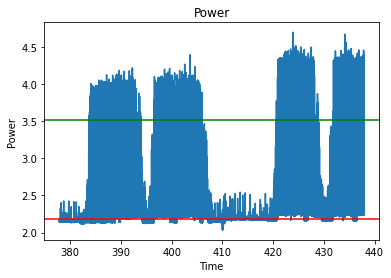

37158 36978
next start: 410028


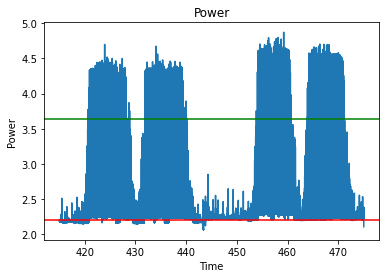

33396 33203
next start: 443424


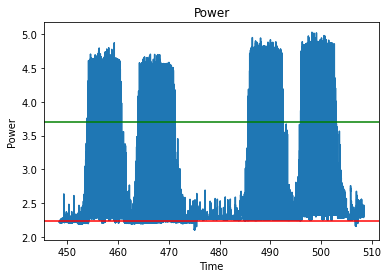

31676 31506
next start: 475100


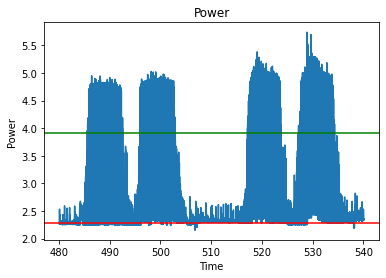

31748 31612
next start: 506848


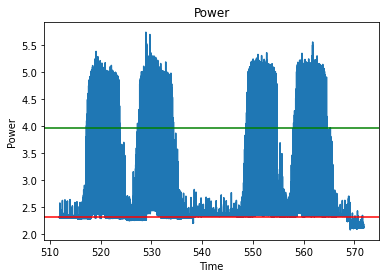

31330 31306
next start: 538178


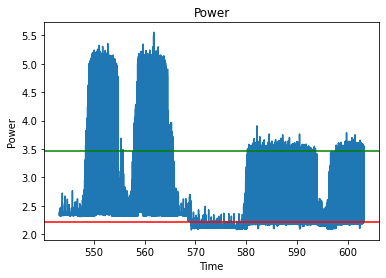

31012 30326
next start: 569190


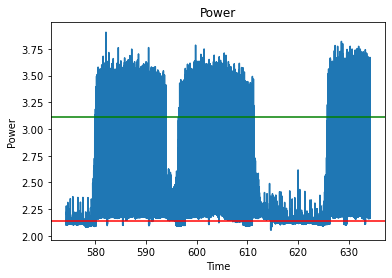

IndexError: single positional indexer is out-of-bounds

In [513]:
final()

Text(0, 0.5, 'Power')

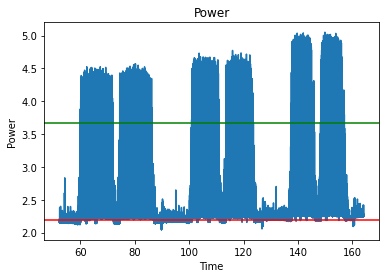

In [442]:
plt.plot(data["Time (s)"], data["Main Avg Power (W)"])
plt.axhline(y = power_active, color = 'g', linestyle = '-')
plt.axhline(y = power_idle, color = 'r', linestyle = '-')
# plt.xticks(range(len(df_new["Time (s)"][::2])), df_new["Time (s)"][::2])
plt.title("Power")
plt.xlabel("Time")
plt.ylabel("Power")